### Importing the dataset

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('Final_HIV.csv')
dataset = dataset.drop(['Headlines', 'Descriptions', 'Authors', 'Published_Dates', 'Publication', 'category', 'Keywords', 'Summaries', 'Source_URLs'], axis=1).dropna().reset_index(drop=True)
dataset.head()

,Articles
0,"Since the beginning of the HIV epidemic, nurse..."
1,Afghanistan is in the early stage of dramatic ...
2,The Ministry of Health has reported that there...
3,"Sunday, December 1st, was World AIDS Day which..."
4,KABUL - Officials of the Ministry of Public He...


### Preliminary text exploration
Before we proceed with any text pre-processing, it is advisable to quickly explore the dataset in terms of word counts, most common and most uncommon words.

### Fetch word count for each abstract

In [3]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['Articles'].apply(lambda x: len(str(x).split(" ")))
dataset[['Articles','word_count']].head()

,Articles,word_count
0,"Since the beginning of the HIV epidemic, nurse...",744
1,Afghanistan is in the early stage of dramatic ...,900
2,The Ministry of Health has reported that there...,840
3,"Sunday, December 1st, was World AIDS Day which...",1011
4,KABUL - Officials of the Ministry of Public He...,296


In [4]:
## Descriptive statistics of word counts
dataset.word_count.describe()

count    2143.000000
mean      448.111993
std       437.385943
min         6.000000
25%       192.000000
50%       334.000000
75%       549.500000
max      5003.000000
Name: word_count, dtype: float64

The average word count is about 428 words per article. The word count ranges from a minimum of 78 to a maximum of 1985. The word count is important to give us an indication of the size of the dataset that we are handling as well as the variation in word counts across the rows.

### Most common and uncommon words
A peek into the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. A comparison of the most common words and the default English stop words will give us a list of words that need to be added to a custom stop word list.

In [5]:
#Identify common words
freq = pd.Series(' '.join(dataset['Articles']).split()).value_counts()[:10]
freq

the     45666
of      29906
and     28582
to      26557
in      19173
a       14874
is       9427
for      9413
with     8556
that     7823
dtype: int64

In [6]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset 
         ['Articles']).split()).value_counts()[-10:]
freq1

2017-2018.               1
everything"              1
re-tendered              1
rebate,                  1
mithunmds07@gmail.com    1
That,                    1
â€œreprehensible         1
HHV6                     1
tested.Use               1
kidnappers,              1
dtype: int64

### Text Pre-processing

In [7]:
# Libraries for text preprocessing
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
import re

**Removing stopwords**: Stop words include the large number of prepositions, pronouns, conjunctions etc in sentences. These words need to be removed before we analyse the text, so that the frequently used words are mainly the words relevant to the context and not common words used in the text.

There is a default list of stopwords in python nltk library. In addition, we might want to add context specific stopwords for which the “most common words” that we listed in the beginning will be helpful. We will now see how to create a list of stopwords and how to add custom stopwords:

In [8]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

We will now carry out the pre-processing tasks step-by-step to get a cleaned and normalised text corpus:

In [9]:
corpus = []
for i in range(0, dataset.word_count.count()):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['Articles'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

Let us now view an item from the corpus:

In [10]:
#View corpus item
corpus[290]

'although bangladesh lower average prevalence rate aid case influx rohingya refugee myanmar triggered fear may bring deadly disease country along cause spread expert expressed concern number aid case bangladesh may unidentified artificially lowering prevalence rate disease total hiv positive rohingya identified refugee camp southern part country far though unicef hiv aid specialist dr ziya uddin said myanmar prevalence rate mean many infected rohingya refugee may arrived remain unidentified added third aid case bangladesh similarly shadow estimated people living hiv bangladesh per asian epidemic model projection data prevalence rate however identified dr ziya said addition said child age among newly identified case year according data national aid std programme people died disease since first aid case identified bangladesh among died year source cox bazar civil surgeon office echoed dr ziya saying may thousand aid affected rohingya refugee camp ukhiya teknaf upazilas disease could spre

### Data Exploration
We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

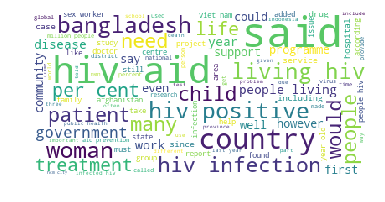

In [11]:
#Word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from os import path

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1000)

## Creating a vector of word counts

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [13]:
list(cv.vocabulary_.keys())[:10]

['since',
 'beginning',
 'epidemic',
 'nurse',
 'forefront',
 'response',
 'fatal',
 'infection',
 'involved',
 'every']

### Visualize top N uni-grams, bi-grams & tri-grams
We can use the CountVectoriser to visualise the top 20 unigrams, bi-grams and tri-grams.

**Bar plot of most frequently occurring uni-grams**

In [14]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["uni-grams", "Freq"]
print(top_df)

     uni-grams   Freq
0          hiv  14106
1          aid   6504
2         said   6277
3       people   5493
4       health   4507
5         year   3270
6      country   2823
7        woman   2781
8    treatment   2610
9    infection   2479
10       child   2363
11        drug   2357
12     disease   2156
13     patient   1861
14       virus   1651
15         day   1625
16  government   1539
17       world   1511
18    positive   1479
19        risk   1457


[Text(0, 0, 'hiv'),
 Text(0, 0, 'aid'),
 Text(0, 0, 'said'),
 Text(0, 0, 'people'),
 Text(0, 0, 'health'),
 Text(0, 0, 'year'),
 Text(0, 0, 'country'),
 Text(0, 0, 'woman'),
 Text(0, 0, 'treatment'),
 Text(0, 0, 'infection'),
 Text(0, 0, 'child'),
 Text(0, 0, 'drug'),
 Text(0, 0, 'disease'),
 Text(0, 0, 'patient'),
 Text(0, 0, 'virus'),
 Text(0, 0, 'day'),
 Text(0, 0, 'government'),
 Text(0, 0, 'world'),
 Text(0, 0, 'positive'),
 Text(0, 0, 'risk')]

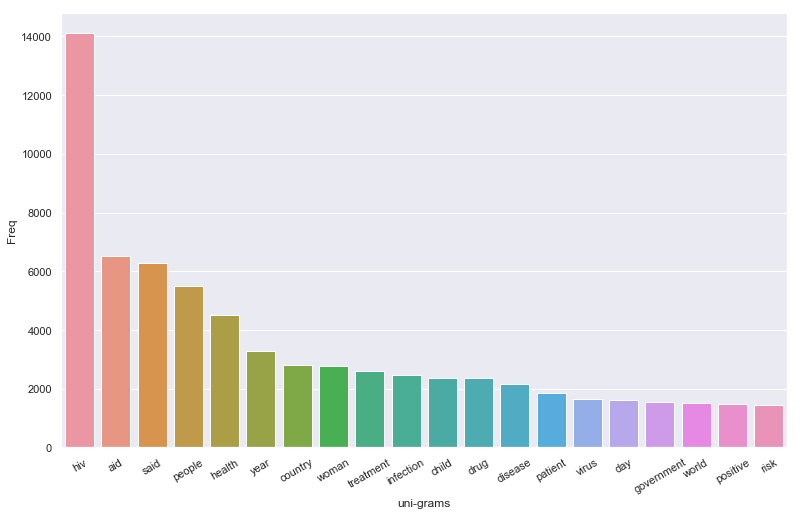

In [15]:
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="uni-grams", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

**Bar plot of most frequently occurring bi-grams**

In [16]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

            Bi-gram  Freq
0           hiv aid  3607
1      hiv positive  1072
2        living hiv  1001
3     hiv infection   947
4          per cent   841
5     people living   765
6   election result   531
7        people hiv   467
8          year old   451
9        sex worker   439
10   aid prevention   437
11         viet nam   430
12   million people   419
13     infected hiv   369
14    public health   353
15        last year   340
16         hcm city   328
17    immune system   316
18           vi nam   299
19     hiv infected   290


[Text(0, 0, 'hiv aid'),
 Text(0, 0, 'hiv positive'),
 Text(0, 0, 'living hiv'),
 Text(0, 0, 'hiv infection'),
 Text(0, 0, 'per cent'),
 Text(0, 0, 'people living'),
 Text(0, 0, 'election result'),
 Text(0, 0, 'people hiv'),
 Text(0, 0, 'year old'),
 Text(0, 0, 'sex worker'),
 Text(0, 0, 'aid prevention'),
 Text(0, 0, 'viet nam'),
 Text(0, 0, 'million people'),
 Text(0, 0, 'infected hiv'),
 Text(0, 0, 'public health'),
 Text(0, 0, 'last year'),
 Text(0, 0, 'hcm city'),
 Text(0, 0, 'immune system'),
 Text(0, 0, 'vi nam'),
 Text(0, 0, 'hiv infected')]

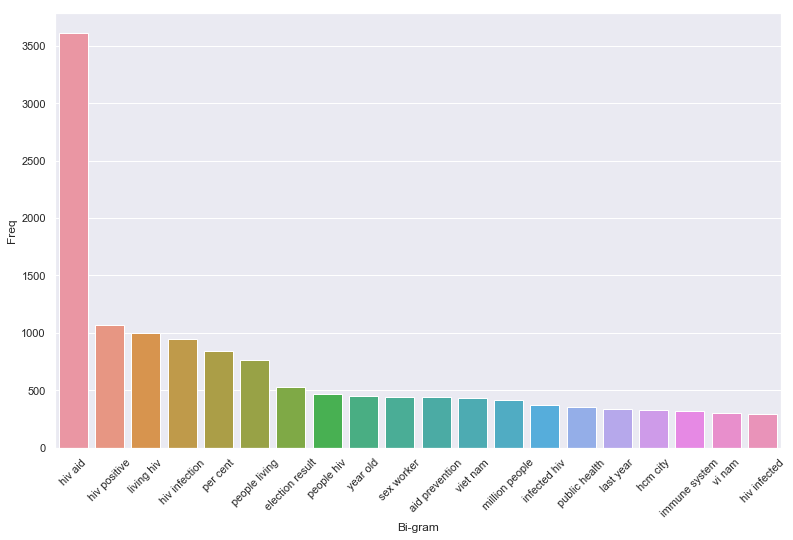

In [17]:
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

### Bar plot of most frequently occurring Tri-grams

In [18]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)

                 Tri-gram  Freq
0       people living hiv   678
1      hiv aid prevention   367
2          living hiv aid   287
3      lok sabha election   266
4         time india news   265
5          india news app   265
6         news app latest   265
7          make sense lok   265
8         sense lok sabha   265
9   sabha election result   265
10    election result may   265
11         result may toi   265
12         may toi follow   265
13       toi follow track   265
14    follow track latest   265
15      track latest news   265
16       latest news live   265
17       news live update   265
18       live update news   265
19   update news analysis   265


[Text(0, 0, 'people living hiv'),
 Text(0, 0, 'hiv aid prevention'),
 Text(0, 0, 'living hiv aid'),
 Text(0, 0, 'lok sabha election'),
 Text(0, 0, 'time india news'),
 Text(0, 0, 'india news app'),
 Text(0, 0, 'news app latest'),
 Text(0, 0, 'make sense lok'),
 Text(0, 0, 'sense lok sabha'),
 Text(0, 0, 'sabha election result'),
 Text(0, 0, 'election result may'),
 Text(0, 0, 'result may toi'),
 Text(0, 0, 'may toi follow'),
 Text(0, 0, 'toi follow track'),
 Text(0, 0, 'follow track latest'),
 Text(0, 0, 'track latest news'),
 Text(0, 0, 'latest news live'),
 Text(0, 0, 'news live update'),
 Text(0, 0, 'live update news'),
 Text(0, 0, 'update news analysis')]

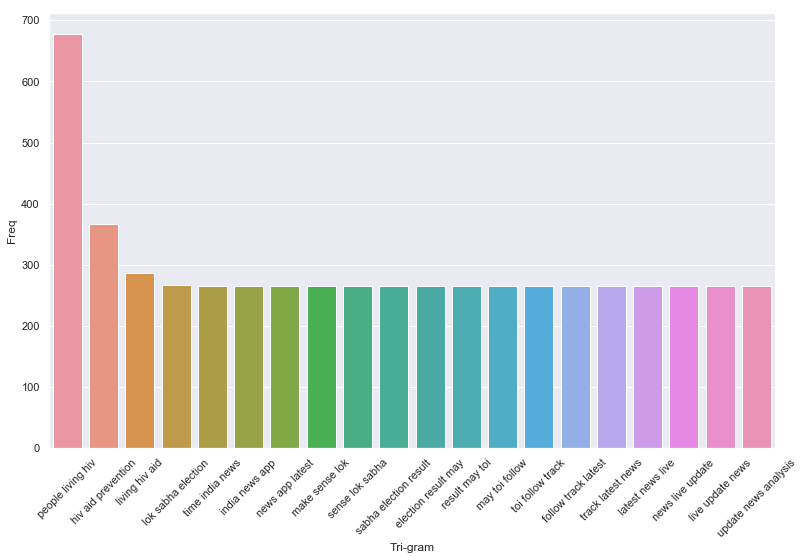

In [19]:
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

### Converting to a matrix of integers

The next step of refining the word counts is using the TF-IDF vectoriser. The deficiency of a mere word count obtained from the countVectoriser is that, large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectoriser which penalizes words that appear several times across the document. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

**TF-IDF consists of 2 components:**

- TF — term frequency

- IDF — Inverse document frequency

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[222]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.

In [21]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
kzn health department ready implement test treat policy hiv positive patient province world health organisation said early anti retroviral arv treatment greatly benefit people infected virus mean hiv infected people get arvs regardless cd count million people hiv positive south africa million live kzn kzn health mec dr sibongiseni dhlomo spoke kwadabeka community health centre west durban thursday national department health emphasised implementation policy contribute national development plan goal increasing citizen life expectancy least year said people diagnosed hiv live long healthy life arv medication health department kzn good position trained many nurse administer arvs size task hand cannot rely doctor provide treatment monitoring patient said department aware policy going hiv positive people getting treatment might lead overcrowding increased waiting time health facility decrease burden patient health facility department initiated process transferring stable patient s